# Datasets & DataLoaders

`torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

PyTorch domain libraries provide a number of pre-loaded datasets (such as FashionMNIST) that subclass`torch.utils.data.Dataset` and implement functions specific to the particular data. They can be used to prototype and benchmark your model.

## Load Dataset
Example : https://github.com/zalandoresearch/fashion-mnist/tree/master
### We load the FashionMNIST Dataset with the following parameters:
* `root` is the path where the train/test data is stored,
* `train` specifies training or test dataset,
* `download=True` downloads the data from the internet if it’s not available at root.
* `transform` and `target_transform` specify the **feature and label transformations**

In [6]:
import torch
from torch.utils.data import Dataset            # Importing the Dataset class from torch.utils.data
from torchvision import datasets                # Importing datasets module from torchvision
from torchvision.transforms import ToTensor     # Importing ToTensor transform from torchvision.transforms
import matplotlib.pyplot as plt

In [7]:
training_data = datasets.FashionMNIST(
    root="data",            # directory to store the dataset
    train=True,             # specify training set
    download=True,          # download if not already present
    transform=ToTensor()    # convert images to PyTorch tensors
)

test_data = datasets.FashionMNIST(
    root="data",            # directory to store the dataset
    train=False,            # specify test set
    download=True,          # download if not already present
    transform=ToTensor()    
)

100.0%


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw


100.0%


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw




8.2%

100.0%
100.0%


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



### Iterating and Visualizing the Dataset

* **Index Datasets manually** like a list: `training_data[index]`. 
* **Use matplotlib** to visualize some samples in our training data.

In [8]:
labels_map = {          # Mapping of label indices to class names
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

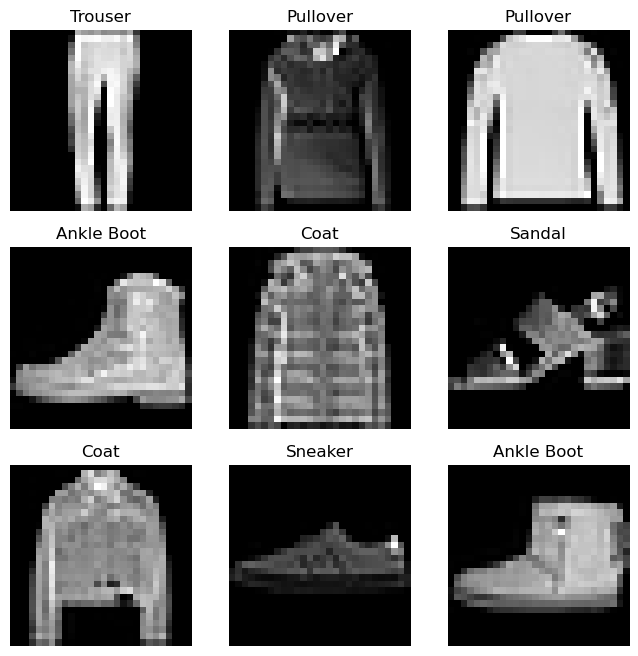

In [9]:
figure = plt.figure(figsize=(8, 8)) # Create a new figure for plotting
cols, rows = 3, 3
for i in range(1, cols * rows + 1): # Loop to create a grid of images
    # .randint generates a random integer within the specified range
    # .item() extracts the integer value from the tensor
    sample_idx = torch.randint(len(training_data), size=(1,)).item() # Randomly select an index
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Creating a Custom Dataset for your files

A custom Dataset class **must implement three functions**: `__init__`, `__len__`, and `__getitem__` 

Take a look at this implementation; the FashionMNIST images are stored in a directory img_dir, and their labels are stored separately in a CSV file annotations_file.

In [10]:
import os                                   # Importing os module for file path operations
import pandas as pd                         # Importing pandas for handling CSV files
from torchvision.io import decode_image     # Importing decode_image function from torchvision.io

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file) # Read the CSV file containing image labels
        self.img_dir = img_dir                          # Directory containing the images
        self.transform = transform                      # Optional transform for images
        self.target_transform = target_transform        # Optional transform for labels

    def __len__(self):                      # Return the total number of samples in the dataset
        return len(self.img_labels)

    def __getitem__(self, idx):             # Retrieve a sample from the dataset at the given index
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]) 
        image = decode_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### Preparing your data for training with DataLoaders

The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to **pass samples in “minibatches”**, **reshuffle the data at every epoch** to **reduce model overfitting**, and use Python’s multiprocessing to speed up data retrieval.

DataLoader is an iterable that abstracts this complexity for us in an easy API.

<details> 
<summary>Terms 설명 </summary>

### 1️. `minibatches`

* **샘플 전체가 아니라 일부만 묶어서 한 번에 학습시키는 단위**
* 예시:

  * 데이터 전체: 10,000개 이미지
  * 배치 크기(batch_size) = 64
  * → **한 번에 64개씩** 모델에 넣어서 학습
* 장점:

  1. 메모리 부담 ↓ (모든 데이터를 한 번에 GPU에 올릴 필요 없음)
  2. 학습 속도 ↑ (GPU 병렬 연산 활용 가능)
  3. **노이즈가 섞여서 최적화가 더 일반화됨**

> **minibatch = 작은 묶음 학습 단위**

### 2. `epoch`

* **전체 데이터셋을 한 번 다 학습시키는 과정**
* 예시:

  * 데이터 10,000개
  * 배치 64 → 한 epoch = 10,000 / 64 ≈ 157번 배치 업데이트
* 머신러닝/딥러닝에서 epoch 여러 번 돌리면서 **모델이 점점 학습**

💡 한 번 epoch 돌린다고 완벽하게 학습되는 건 아님

* 5 epoch, 10 epoch 등 반복해서 학습

### 3️. `reshuffle at every epoch`

* 학습 데이터 순서를 매번 **무작위로 섞음**
* 이유:

  1. 모델이 특정 순서/패턴에 **편향되지 않도록**
  2. **overfitting 완화**

### 4. `overfitting` (과적합)

* 모델이 **훈련 데이터에는 너무 잘 맞지만**, 새로운 데이터(테스트 데이터)에는 성능이 떨어지는 현상

* 예시:

  * 훈련 데이터: 고양이/강아지 사진 100개 → 모델 100% 정확
  * 새로운 사진: 정확도 60%

* 원인:

  * 모델이 **데이터의 노이즈까지 외워버림**
  * 일반화 능력 부족

* 해결 방법:

  1. **데이터 섞기 / minibatch 학습**
  2. **정규화, dropout**
  3. 데이터 augmentation

### 5️. DataLoader가 하는 일

`Dataset` = 한 샘플씩만 제공
`DataLoader` = 학습 편의성을 위해:

1. **미니배치(batch) 단위로 묶어줌**
2. **shuffle=True** → 매 epoch마다 데이터 섞기
3. **num_workers > 0** → 멀티프로세싱으로 데이터 로딩 속도 향상
4. **Iterable** → for문으로 쉽게 학습 가능

```python
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,    # 매 epoch마다 섞기
    num_workers=4    # 멀티프로세싱
)

for batch_features, batch_labels in train_loader:
    # 학습 코드
    pass
```

### 정리

| 단계         | 설명                                                 |
| ---------- | -------------------------------------------------- |
| Dataset    | 데이터 1개씩 반환                                         |
| DataLoader | → batch_size 묶음 → GPU로 올릴 준비 → shuffle → 반복(epoch) |

* `minibatches` → 작은 묶음으로 학습, 메모리/성능 최적화
* `epoch` → 전체 데이터를 한 번 다 학습
* `reshuffle` →매 epoch마다 데이터 순서 섞기 → overfitting 완화
* `overfitting` → 훈련 데이터만 외워서 일반화 안 되는 문제

</details>

In [11]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

### Iterate through the DataLoader

We have loaded that dataset into the DataLoader and can iterate through the dataset as needed.

Each iteration below returns a **batch of `train_features` and `train_labels`** (containing batch_size=64 features and labels respectively). Because we specified `shuffle=True`, after we iterate over all batches the data is shuffled (for finer-grained control over the data loading order, take a look at Samplers).

In [ ]:
# Display image and label.
# next(iter(...)) gets the first batch from the dataloader
train_features, train_labels = next(iter(train_dataloader)) 
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0].squeeze() 
# .squeeze() removes single-dimensional entries from the shape of the tensor
# the reason we need to squeeze is that the image tensor has shape (1, 28, 28)
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")